In [1]:
# ========================================
# CELLULE 1 - Imports (SANS MODIFICATION)
# ========================================

# imports pour manipulation de données
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# imports pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# imports pour preprocessing et validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import class_weight

# imports pour deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

# imports pour analyse spatiale
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import networkx as nx

# configuration gpu si disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
# seed pour reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

# configuration des paramètres d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print(f"tensorflow version: {tf.__version__}")
print(f"gpu disponible: {len(physical_devices) > 0}")

2025-07-09 04:26:14.764169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 04:26:14.793139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 04:26:14.793172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 04:26:14.794163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 04:26:14.800805: I tensorflow/core/platform/cpu_feature_guar

tensorflow version: 2.15.0
gpu disponible: False


In [2]:
# ========================================
# CELLULE 2 - Chargement des données (SANS MODIFICATION)
# ========================================

# chargement du dataset
df = pd.read_csv('./ProcessedData2/covid_weekly_final.csv')

# informations générales
print(f"shape du dataset: {df.shape}")
print(f"periode couverte: {df['week_start'].min()} à {df['week_end'].max()}")
print(f"nombre de pays/territoires: {df['location'].nunique()}")
print(f"nombre de continents: {df['continent'].nunique()}")
print(f"\ntypes de données:")
print(df.dtypes)

# verification des valeurs manquantes
print(f"\n\nvaleurs manquantes par colonne:")
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'count': missing_counts[missing_counts > 0],
    'percent': missing_percent[missing_counts > 0]
}).sort_values('percent', ascending=False)
print(missing_df)

# apercu des donnees
print(f"\n\npremières lignes:")
print(df.head())

# statistiques sur les colonnes clés pour la modélisation
key_cols = ['weekly_cases', 'weekly_deaths', 'weekly_cases_capped', 'weekly_deaths_capped',
            'log_weekly_cases', 'log_weekly_deaths', 'avg_reproduction_rate', 
            'avg_mortality_rate', 'avg_stringency_index']

print(f"\n\nstatistiques des colonnes clés:")
print(df[key_cols].describe())

# distribution des poids de regression
print(f"\n\ndistribution des poids de regression:")
print(df['regression_weight_adjusted'].value_counts().sort_index())

# proportion des outliers
print(f"\n\nproportion des outliers:")
print(f"outliers extremes: {df['is_extreme_outlier'].sum() / len(df) * 100:.2f}%")
print(f"outliers standards: {df['is_outlier'].sum() / len(df) * 100:.2f}%")

shape du dataset: (56874, 35)
periode couverte: 2019-12-30 à 2024-08-18
nombre de pays/territoires: 234
nombre de continents: 6

types de données:
location                       object
iso_code                       object
continent                      object
year_week                      object
week_start                     object
week_end                       object
weekly_cases                  float64
weekly_deaths                 float64
total_cases                   float64
total_deaths                  float64
weekly_cases_capped           float64
weekly_deaths_capped          float64
log_weekly_cases              float64
log_weekly_deaths             float64
avg_daily_cases_smoothed      float64
avg_daily_deaths_smoothed     float64
avg_cases_per_million         float64
avg_deaths_per_million        float64
avg_reproduction_rate         float64
avg_mortality_rate            float64
avg_stringency_index          float64
cases_growth_rate             float64
deaths_growth_rat

In [3]:
# ========================================
# CELLULE 3 - Feature Engineering (SANS MODIFICATION)
# ========================================

# conversion des dates
df['week_start'] = pd.to_datetime(df['week_start'])
df['week_end'] = pd.to_datetime(df['week_end'])

# extraction des composantes temporelles
df['year'] = df['week_start'].dt.year
df['week_of_year'] = df['week_start'].dt.isocalendar().week
df['month'] = df['week_start'].dt.month
df['quarter'] = df['week_start'].dt.quarter

# calcul du nombre de semaines depuis le début de la pandémie
pandemic_start = df['week_start'].min()
df['weeks_since_start'] = (df['week_start'] - pandemic_start).dt.days / 7

# encodage cyclique pour capturer la saisonnalité
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# création de features pour les phases épidémiques
# phase approximative basée sur le temps écoulé
df['phase_early'] = (df['weeks_since_start'] < 12).astype(int)  # 3 premiers mois
df['phase_peak1'] = ((df['weeks_since_start'] >= 12) & (df['weeks_since_start'] < 26)).astype(int)  # mois 3-6
df['phase_summer2020'] = ((df['weeks_since_start'] >= 26) & (df['weeks_since_start'] < 39)).astype(int)  # été 2020
df['phase_wave2'] = ((df['weeks_since_start'] >= 39) & (df['weeks_since_start'] < 65)).astype(int)  # 2ème vague
df['phase_vaccination'] = (df['weeks_since_start'] >= 52).astype(int)  # après 1 an

# calcul de la matrice de distances géographiques entre pays
locations_with_coords = df[['location', 'latitude', 'longitude']].dropna().drop_duplicates()
print(f"nombre de pays avec coordonnées complètes: {len(locations_with_coords)}")

# creation d'un dictionnaire de coordonnées
coords_dict = {}
for _, row in locations_with_coords.iterrows():
    coords_dict[row['location']] = (row['latitude'], row['longitude'])

# calcul des distances entre tous les pays (en km)
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371  # rayon de la terre en km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return r * c

# creation d'une matrice de distances
countries = list(coords_dict.keys())
n_countries = len(countries)
distance_matrix = np.zeros((n_countries, n_countries))

for i, country1 in enumerate(countries):
    for j, country2 in enumerate(countries):
        if i != j:
            lat1, lon1 = coords_dict[country1]
            lat2, lon2 = coords_dict[country2]
            distance_matrix[i, j] = haversine_distance(lat1, lon1, lat2, lon2)

# sauvegarde pour usage ultérieur
distance_df = pd.DataFrame(distance_matrix, index=countries, columns=countries)
print(f"\nmatrice de distances créée: {distance_df.shape}")
print(f"distance moyenne entre pays: {distance_matrix[distance_matrix > 0].mean():.0f} km")

# ajout de features géographiques au dataset
# nombre de pays voisins dans un rayon de 1000km
neighbor_counts = {}
for country in countries:
    if country in distance_df.index:
        neighbors = (distance_df.loc[country] < 1000) & (distance_df.loc[country] > 0)
        neighbor_counts[country] = neighbors.sum()

df['neighbor_count_1000km'] = df['location'].map(neighbor_counts).fillna(0)

# indicateur de connectivité continentale
continent_sizes = df.groupby('continent')['location'].nunique()
df['continent_connectivity'] = df['continent'].map(continent_sizes)

print(f"\n\nnouvelles colonnes créées:")
new_cols = [col for col in df.columns if col not in ['location', 'iso_code', 'continent', 'year_week', 
                                                       'week_start', 'week_end', 'weekly_cases', 'weekly_deaths',
                                                       'total_cases', 'total_deaths', 'weekly_cases_capped', 
                                                       'weekly_deaths_capped', 'log_weekly_cases', 'log_weekly_deaths',
                                                       'avg_daily_cases_smoothed', 'avg_daily_deaths_smoothed',
                                                       'avg_cases_per_million', 'avg_deaths_per_million',
                                                       'avg_reproduction_rate', 'avg_mortality_rate', 'avg_stringency_index',
                                                       'cases_growth_rate', 'deaths_growth_rate', 'population',
                                                       'population_density', 'latitude', 'longitude', 'days_with_data',
                                                       'data_quality', 'is_outlier', 'is_extreme_outlier',
                                                       'regression_weight', 'regression_weight_adjusted',
                                                       'extreme_cases', 'extreme_deaths']]
print(new_cols)

# verification des features temporelles
print(f"\n\nverification des encodages cycliques:")
print(f"week_sin range: [{df['week_sin'].min():.3f}, {df['week_sin'].max():.3f}]")
print(f"week_cos range: [{df['week_cos'].min():.3f}, {df['week_cos'].max():.3f}]")
print(f"weeks_since_start range: [{df['weeks_since_start'].min():.1f}, {df['weeks_since_start'].max():.1f}]")

nombre de pays avec coordonnées complètes: 228

matrice de distances créée: (228, 228)
distance moyenne entre pays: 8333 km


nouvelles colonnes créées:
['year', 'week_of_year', 'month', 'quarter', 'weeks_since_start', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'phase_early', 'phase_peak1', 'phase_summer2020', 'phase_wave2', 'phase_vaccination', 'neighbor_count_1000km', 'continent_connectivity']


verification des encodages cycliques:
week_sin range: [-1.000, 1.000]
week_cos range: [-1.000, 1.000]
weeks_since_start range: [0.0, 241.0]


NOUVELLES statistiques des variables cibles:

target_mortality_rate:
  mean: 0.4932
  std: 0.4005
  min: 0.0000
  max: 1.0000
  variance: 0.160394

target_transmission_rate:
  mean: 0.4987
  std: 0.0270
  min: 0.0000
  max: 0.9676
  variance: 0.000730

target_spatial_spread:
  mean: 0.1179
  std: 0.2343
  min: 0.0000
  max: 1.0000
  variance: 0.054874


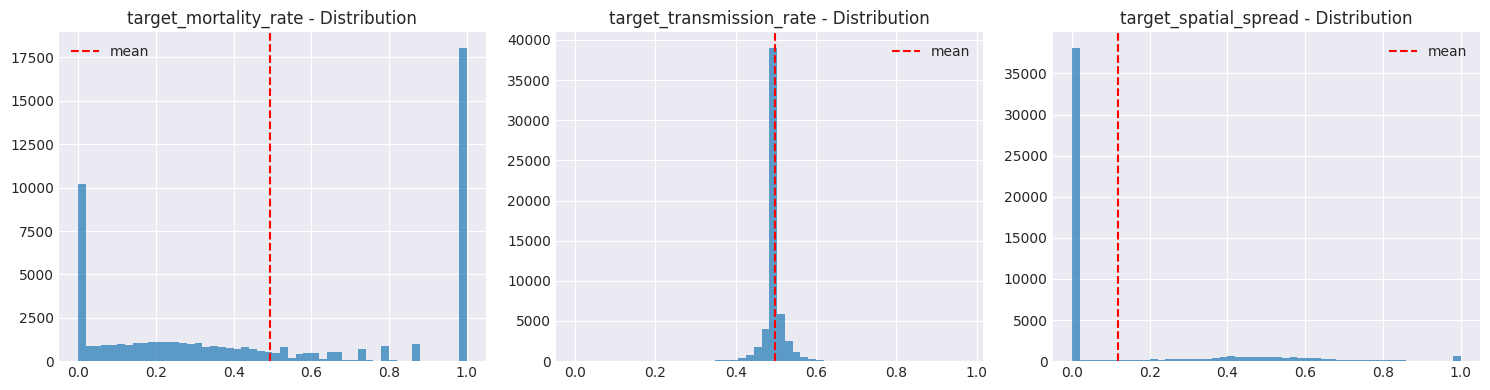



corrélations entre les targets:
                          target_mortality_rate  target_transmission_rate  \
target_mortality_rate                     1.000                     0.024   
target_transmission_rate                  0.024                     1.000   
target_spatial_spread                    -0.199                     0.042   

                          target_spatial_spread  
target_mortality_rate                    -0.199  
target_transmission_rate                  0.042  
target_spatial_spread                     1.000  


valeurs manquantes finales:
target_spatial_spread    6602
dtype: int64


dataset sauvegardé: covid_data_prepared.pkl
shape finale: (56874, 63)


In [4]:
# ========================================
# CELLULE 4 - Préparation des données (VERSION CORRIGÉE)
# ========================================

# stratégie de traitement des valeurs manquantes
# on va créer des indicateurs de missingness avant imputation
missing_indicators = ['avg_reproduction_rate', 'deaths_growth_rate', 'avg_stringency_index', 
                     'cases_growth_rate', 'avg_mortality_rate']

for col in missing_indicators:
    df[f'{col}_was_missing'] = df[col].isna().astype(int)

# imputation des valeurs manquantes
# pour les coordonnées géographiques, on utilise la médiane par continent
for continent in df['continent'].unique():
    if pd.notna(continent):
        mask = df['continent'] == continent
        df.loc[mask, 'latitude'] = df.loc[mask, 'latitude'].fillna(df.loc[mask, 'latitude'].median())
        df.loc[mask, 'longitude'] = df.loc[mask, 'longitude'].fillna(df.loc[mask, 'longitude'].median())
        df.loc[mask, 'population_density'] = df.loc[mask, 'population_density'].fillna(df.loc[mask, 'population_density'].median())

# pour les métriques épidémiques, on fait un forward fill par pays puis backward fill
epidemio_cols = ['avg_reproduction_rate', 'avg_mortality_rate', 'avg_stringency_index',
                 'cases_growth_rate', 'deaths_growth_rate', 'avg_daily_cases_smoothed',
                 'avg_daily_deaths_smoothed', 'avg_cases_per_million', 'avg_deaths_per_million']

df_sorted = df.sort_values(['location', 'week_start'])
for col in epidemio_cols:
    df_sorted[col] = df_sorted.groupby('location')[col].fillna(method='ffill').fillna(method='bfill')

# pour les valeurs toujours manquantes, on utilise 0 ou la médiane globale
df_sorted['avg_reproduction_rate'] = df_sorted['avg_reproduction_rate'].fillna(1.0)  # r0 neutre
df_sorted['avg_mortality_rate'] = df_sorted['avg_mortality_rate'].fillna(0.0)
df_sorted['avg_stringency_index'] = df_sorted['avg_stringency_index'].fillna(0.0)
df_sorted['cases_growth_rate'] = df_sorted['cases_growth_rate'].fillna(0.0)
df_sorted['deaths_growth_rate'] = df_sorted['deaths_growth_rate'].fillna(0.0)

# remplissage des dernières valeurs manquantes
for col in df_sorted.columns:
    if df_sorted[col].dtype in ['float64', 'int64'] and df_sorted[col].isna().any():
        df_sorted[col] = df_sorted[col].fillna(0)

df = df_sorted.copy()

# ====== NOUVELLES TARGETS SIMPLIFIÉES ======

# 1. MORTALITY RATE - Version améliorée
# Utilisation du ratio log pour capturer plus de variance
df['log_cases'] = np.log1p(df['weekly_cases'])
df['log_deaths'] = np.log1p(df['weekly_deaths'])
df['target_mortality_rate'] = (df['log_deaths'] - df['log_cases']).clip(-5, 0)
df['target_mortality_rate'] = (df['target_mortality_rate'] + 5) / 5

# 2. TRANSMISSION RATE - Changements relatifs
# Capture les variations plutôt que les valeurs absolues
df['ma_reproduction'] = df.groupby('location')['avg_reproduction_rate'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()
)
df['target_transmission_rate'] = (df['avg_reproduction_rate'] - df['ma_reproduction']).clip(-2, 2)
df['target_transmission_rate'] = (df['target_transmission_rate'] + 2) / 4

# 3. SPATIAL SPREAD - Version simplifiée basée sur la croissance locale vs régionale
df['regional_growth'] = df.groupby(['continent', 'week_start'])['cases_growth_rate'].transform('mean')
df['target_spatial_spread'] = (df['cases_growth_rate'] - df['regional_growth']).clip(-1, 1)
df['target_spatial_spread'] = (df['target_spatial_spread'] + 1) / 2

# Vérification de la variance
print("NOUVELLES statistiques des variables cibles:")
target_cols = ['target_mortality_rate', 'target_transmission_rate', 'target_spatial_spread']
for col in target_cols:
    print(f"\n{col}:")
    print(f"  mean: {df[col].mean():.4f}")
    print(f"  std: {df[col].std():.4f}")
    print(f"  min: {df[col].min():.4f}")
    print(f"  max: {df[col].max():.4f}")
    print(f"  variance: {df[col].var():.6f}")

# Visualisation rapide
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(target_cols):
    axes[i].hist(df[col].dropna(), bins=50, alpha=0.7)
    axes[i].set_title(f'{col} - Distribution')
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label='mean')
    axes[i].legend()
plt.tight_layout()
plt.show()

print(f"\n\ncorrélations entre les targets:")
print(df[target_cols].corr())

print(f"\n\nvaleurs manquantes finales:")
print(df.isna().sum()[df.isna().sum() > 0])

# sauvegarde du dataframe préparé
df.to_pickle('covid_data_prepared.pkl')
print(f"\n\ndataset sauvegardé: covid_data_prepared.pkl")
print(f"shape finale: {df.shape}")

In [5]:
# ========================================
# CELLULE 5 - Création des séquences (SANS MODIFICATION)
# ========================================

# chargement des données préparées
df = pd.read_pickle('covid_data_prepared.pkl')

# fonction pour détecter les phases épidémiques dynamiquement
def detect_epidemic_phases(country_data):
    """
    détecte les phases épidémiques basées sur les indicateurs dynamiques
    plutôt que sur des dates fixes
    """
    phases = np.zeros(len(country_data))
    
    # calcul des indicateurs sur fenêtre glissante
    window = 3  # fenêtre de 3 semaines pour lisser
    
    # moving averages
    ma_cases = country_data['log_weekly_cases'].rolling(window, center=True, min_periods=1).mean()
    ma_r0 = country_data['avg_reproduction_rate'].rolling(window, center=True, min_periods=1).mean()
    ma_growth = country_data['cases_growth_rate'].rolling(window, center=True, min_periods=1).mean()
    
    # détection des phases
    for i in range(len(country_data)):
        # phase 0: pre-épidémique (très peu de cas)
        if ma_cases.iloc[i] < 1.0:  # log(e) = 1, donc moins de ~3 cas
            phases[i] = 0
        # phase 1: croissance initiale (r0 > 1.5 et croissance positive)
        elif ma_r0.iloc[i] > 1.5 and ma_growth.iloc[i] > 0.1:
            phases[i] = 1
        # phase 2: pic (r0 proche de 1, croissance ralentit)
        elif 0.8 <= ma_r0.iloc[i] <= 1.2 and abs(ma_growth.iloc[i]) < 0.1:
            phases[i] = 2
        # phase 3: déclin (r0 < 0.8 ou croissance négative forte)
        elif ma_r0.iloc[i] < 0.8 or ma_growth.iloc[i] < -0.1:
            phases[i] = 3
        # phase 4: endémique/contrôlé (cas stables à niveau bas)
        elif ma_cases.iloc[i] < 3.0 and abs(ma_growth.iloc[i]) < 0.05:
            phases[i] = 4
        # phase 5: résurgence (nouvelle croissance après déclin)
        elif i > 20 and phases[i-10:i].mean() > 2 and ma_growth.iloc[i] > 0.1:
            phases[i] = 5
        else:
            # par défaut, on propage la phase précédente
            phases[i] = phases[i-1] if i > 0 else 1
    
    return phases

# application de la détection de phases par pays
print("détection des phases épidémiques dynamiques...")
df['epidemic_phase'] = 0

for country in df['location'].unique():
    mask = df['location'] == country
    country_data = df[mask].sort_values('week_start').reset_index(drop=True)
    
    if len(country_data) > 10:  # suffisamment de données
        phases = detect_epidemic_phases(country_data)
        df.loc[mask, 'epidemic_phase'] = phases

# création des features de phase (one-hot encoding)
phase_names = ['pre_epidemic', 'growth', 'peak', 'decline', 'controlled', 'resurgence']
for i, phase_name in enumerate(phase_names):
    df[f'phase_{phase_name}'] = (df['epidemic_phase'] == i).astype(int)

print(f"distribution des phases épidémiques:")
phase_counts = df['epidemic_phase'].value_counts().sort_index()
for i, count in phase_counts.items():
    if i < len(phase_names):
        print(f"phase {i} ({phase_names[i]}): {count} ({count/len(df)*100:.1f}%)")

# sélection des features pour le modèle
feature_cols = [
    # variables épidémiologiques (transformées pour stabilité)
    'log_weekly_cases', 'log_weekly_deaths',
    'avg_cases_per_million', 'avg_deaths_per_million',
    'avg_reproduction_rate', 'avg_mortality_rate',
    'cases_growth_rate', 'deaths_growth_rate',
    
    # mesures de contrôle
    'avg_stringency_index',
    
    # features temporelles (génériques, pas spécifiques au covid)
    'weeks_since_start', 'week_sin', 'week_cos', 'month_sin', 'month_cos',
    
    # phases épidémiques dynamiques
    'phase_pre_epidemic', 'phase_growth', 'phase_peak', 
    'phase_decline', 'phase_controlled', 'phase_resurgence',
    
    # features géographiques
    'population_density', 'neighbor_count_1000km', 'continent_connectivity',
    
    # indicateurs de qualité des données
    'regression_weight_adjusted',
    'avg_reproduction_rate_was_missing', 'deaths_growth_rate_was_missing',
    'avg_stringency_index_was_missing', 'cases_growth_rate_was_missing',
    'avg_mortality_rate_was_missing'
]

target_cols = ['target_mortality_rate', 'target_transmission_rate', 'target_spatial_spread']

# vérification et traitement des valeurs problématiques
print("\nvérification des valeurs problématiques dans les features:")
for col in feature_cols:
    if col in df.columns:
        inf_count = np.isinf(df[col]).sum()
        nan_count = df[col].isna().sum()
        if inf_count > 0 or nan_count > 0:
            print(f"{col}: {inf_count} inf, {nan_count} nan")
            # remplacement des inf par des valeurs extremes mais finies
            df[col] = df[col].replace([np.inf, -np.inf], [df[col][np.isfinite(df[col])].max(), 
                                                           df[col][np.isfinite(df[col])].min()])
            # remplacement des nan restants par 0
            df[col] = df[col].fillna(0)

# capping des growth rates extremes
growth_rate_cols = ['cases_growth_rate', 'deaths_growth_rate']
for col in growth_rate_cols:
    df[col] = df[col].clip(-10, 10)

# normalisation robuste des features
scaler_features = RobustScaler(quantile_range=(5, 95))
scaler_targets = StandardScaler()  # CHANGÉ de MinMaxScaler

# fit sur les données avec poids élevé uniquement
high_quality_mask = df['regression_weight_adjusted'] >= 0.5
features_scaled = scaler_features.fit_transform(df.loc[high_quality_mask, feature_cols])

# transform sur toutes les données
df_features_scaled = pd.DataFrame(
    scaler_features.transform(df[feature_cols]),
    columns=feature_cols,
    index=df.index
)

df_targets_scaled = pd.DataFrame(
    scaler_targets.fit_transform(df[target_cols]),
    columns=target_cols,
    index=df.index
)

# fonction pour créer des séquences
def create_sequences(country_data, sequence_length=12, prediction_horizon=4):
    """
    crée des séquences pour lstm
    sequence_length: nombre de semaines historiques
    prediction_horizon: nombre de semaines à prédire
    """
    sequences = []
    targets = []
    weights = []
    metadata = []
    
    n_samples = len(country_data) - sequence_length - prediction_horizon + 1
    
    for i in range(n_samples):
        # sequence historique
        seq_features = country_data[feature_cols].iloc[i:i+sequence_length].values
        
        # targets futures (moyenne sur l'horizon de prédiction)
        future_targets = country_data[target_cols].iloc[i+sequence_length:i+sequence_length+prediction_horizon].mean().values
        
        # poids de régression (minimum sur la séquence)
        seq_weights = country_data['regression_weight_adjusted'].iloc[i:i+sequence_length+prediction_horizon].min()
        
        # metadata incluant la phase dominante
        dominant_phase = country_data['epidemic_phase'].iloc[i+sequence_length:i+sequence_length+prediction_horizon].mode()[0]
        meta = {
            'location': country_data['location'].iloc[i],
            'week_start': country_data['week_start'].iloc[i+sequence_length],
            'epidemic_phase': dominant_phase,
            'weeks_since_start': country_data['weeks_since_start'].iloc[i+sequence_length]
        }
        
        sequences.append(seq_features)
        targets.append(future_targets)
        weights.append(seq_weights)
        metadata.append(meta)
    
    return sequences, targets, weights, metadata

# création des séquences par pays
all_sequences = []
all_targets = []
all_weights = []
all_metadata = []

sequence_length = 12  # 3 mois d'historique
prediction_horizon = 4  # prédiction sur 1 mois

countries = df['location'].unique()
print(f"\ncréation des séquences pour {len(countries)} pays...")

for country in countries:
    country_data = df[df['location'] == country].sort_values('week_start').reset_index(drop=True)
    
    # on ne prend que les pays avec suffisamment de données
    if len(country_data) >= sequence_length + prediction_horizon:
        # merge avec les features et targets normalisés
        country_features = df_features_scaled[df_features_scaled.index.isin(country_data.index)]
        country_targets = df_targets_scaled[df_targets_scaled.index.isin(country_data.index)]
        
        country_data_scaled = country_data.copy()
        country_data_scaled[feature_cols] = country_features.values
        country_data_scaled[target_cols] = country_targets.values
        
        sequences, targets, weights, metadata = create_sequences(
            country_data_scaled, 
            sequence_length, 
            prediction_horizon
        )
        
        all_sequences.extend(sequences)
        all_targets.extend(targets)
        all_weights.extend(weights)
        all_metadata.extend(metadata)

# conversion en arrays numpy
x = np.array(all_sequences)
y = np.array(all_targets)
sample_weights = np.array(all_weights)

print(f"\nshape des données:")
print(f"x (features): {x.shape}")
print(f"y (targets): {y.shape}")
print(f"sample_weights: {sample_weights.shape}")

# distribution des poids
print(f"\ndistribution des poids d'échantillons:")
print(pd.Series(sample_weights).value_counts().sort_index())

# analyse des phases représentées
metadata_df = pd.DataFrame(all_metadata)
print(f"\nrépartition par phase épidémique dynamique:")
phase_dist = metadata_df['epidemic_phase'].value_counts().sort_index()
for phase, count in phase_dist.items():
    if phase < len(phase_names):
        print(f"phase {phase} ({phase_names[phase]}): {count} ({count/len(metadata_df)*100:.1f}%)")

# sauvegarde des données préparées
np.savez('lstm_sequences.npz', 
         x=x, y=y, sample_weights=sample_weights,
         feature_names=feature_cols,
         target_names=target_cols)

# sauvegarde des scalers
import joblib
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_targets, 'scaler_targets.pkl')

# sauvegarde metadata
metadata_df.to_pickle('sequences_metadata.pkl')

# sauvegarde du dataframe mis à jour avec les phases
df.to_pickle('covid_data_with_phases.pkl')

print(f"\nfichiers sauvegardés:")
print("- lstm_sequences.npz")
print("- scaler_features.pkl")
print("- scaler_targets.pkl")
print("- sequences_metadata.pkl")
print("- covid_data_with_phases.pkl")

détection des phases épidémiques dynamiques...
distribution des phases épidémiques:
phase 0 (pre_epidemic): 18584 (32.7%)
phase 1 (growth): 2084 (3.7%)
phase 2 (peak): 6773 (11.9%)
phase 3 (decline): 21265 (37.4%)
phase 4 (controlled): 71 (0.1%)
phase 5 (resurgence): 8097 (14.2%)

vérification des valeurs problématiques dans les features:
cases_growth_rate: 6602 inf, 0 nan
deaths_growth_rate: 10535 inf, 0 nan

création des séquences pour 234 pays...

shape des données:
x (features): (53364, 12, 29)
y (targets): (53364, 3)
sample_weights: (53364,)

distribution des poids d'échantillons:
-0.700    24102
-0.500     4926
0.000     24336
Name: count, dtype: int64

répartition par phase épidémique dynamique:
phase 0 (pre_epidemic): 16188 (30.3%)
phase 1 (growth): 2064 (3.9%)
phase 2 (peak): 7399 (13.9%)
phase 3 (decline): 20493 (38.4%)
phase 4 (controlled): 32 (0.1%)
phase 5 (resurgence): 7188 (13.5%)

fichiers sauvegardés:
- lstm_sequences.npz
- scaler_features.pkl
- scaler_targets.pkl
- se

In [6]:
# ========================================
# CELLULE 6 - Split des données (AVEC MODIFICATIONS MINEURES)
# ========================================

# chargement des données
data = np.load('lstm_sequences.npz')
x = data['x']
y = data['y']
sample_weights = data['sample_weights']
feature_names = data['feature_names']
target_names = data['target_names']

# correction des poids négatifs
print("correction des poids d'échantillons...")
sample_weights = np.abs(sample_weights)  # valeur absolue
sample_weights[sample_weights == 0] = 0.1  # poids minimum

# chargement des métadonnées
metadata_df = pd.read_pickle('sequences_metadata.pkl')

# Utilisation du split temporel simple pour la rapidité
print("\nCréation du split temporel simple...")
n_samples = len(x)
train_end = int(0.7 * n_samples)
val_end = int(0.85 * n_samples)

train_idx = np.arange(0, train_end)
val_idx = np.arange(train_end, val_end)
test_idx = np.arange(val_end, n_samples)

print(f"\nSplit temporel:")
print(f"  train: {len(train_idx)} échantillons")
print(f"  val: {len(val_idx)} échantillons") 
print(f"  test: {len(test_idx)} échantillons")

x_train, y_train, w_train = x[train_idx], y[train_idx], sample_weights[train_idx]
x_val, y_val, w_val = x[val_idx], y[val_idx], sample_weights[val_idx]
x_test, y_test, w_test = x[test_idx], y[test_idx], sample_weights[test_idx]

# sauvegarde
np.savez('train_val_test_split.npz',
         x_train=x_train, y_train=y_train, w_train=w_train,
         x_val=x_val, y_val=y_val, w_val=w_val,
         x_test=x_test, y_test=y_test, w_test=w_test,
         train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)

print(f"\nfichier sauvegardé: train_val_test_split.npz")
print(f"shapes finales:")
print(f"  train: {x_train.shape}")
print(f"  val: {x_val.shape}")
print(f"  test: {x_test.shape}")

correction des poids d'échantillons...

Création du split temporel simple...

Split temporel:
  train: 37354 échantillons
  val: 8005 échantillons
  test: 8005 échantillons

fichier sauvegardé: train_val_test_split.npz
shapes finales:
  train: (37354, 12, 29)
  val: (8005, 12, 29)
  test: (8005, 12, 29)


In [7]:
# ========================================
# CELLULE 7 - Architecture du modèle (VERSION SIMPLIFIÉE)
# ========================================

# chargement des données
data = np.load('train_val_test_split.npz')
x_train, y_train, w_train = data['x_train'], data['y_train'], data['w_train']
x_val, y_val, w_val = data['x_val'], data['y_val'], data['w_val']
x_test, y_test, w_test = data['x_test'], data['y_test'], data['w_test']

print(f"dimensions des données:")
print(f"train: {x_train.shape}, poids moyen: {w_train.mean():.3f}")
print(f"val: {x_val.shape}, poids moyen: {w_val.mean():.3f}")
print(f"test: {x_test.shape}, poids moyen: {w_test.mean():.3f}")

print("\nVérification de la variance des targets:")
for i, name in enumerate(['mortality_rate', 'transmission_rate', 'spatial_spread']):
    print(f"{name}: mean={y_train[:,i].mean():.4f}, std={y_train[:,i].std():.4f}")

# ARCHITECTURE SIMPLE ET ROBUSTE
model = tf.keras.Sequential([
    # LSTM simple
    tf.keras.layers.LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), 
                        dropout=0.2, recurrent_dropout=0.1),
    
    # Dense layers
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    # Sortie linéaire
    tf.keras.layers.Dense(3, activation='linear')
])

# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae'],
    weighted_metrics=['mae']
)

print("\nArchitecture du modèle:")
model.summary()

# Callbacks
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Monitor simple
class SimpleMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_pred = self.model.predict(x_val[:100], verbose=0)
            print(f"\nEpoch {epoch} - Std des prédictions: {val_pred.std(axis=0)}")

custom_callback = SimpleMonitor()
callbacks_list.append(custom_callback)

training_callbacks = callbacks_list

print("\nPrêt pour l'entraînement!")

dimensions des données:
train: (37354, 12, 29), poids moyen: 0.408
val: (8005, 12, 29), poids moyen: 0.407
test: (8005, 12, 29), poids moyen: 0.407

Vérification de la variance des targets:
mortality_rate: mean=-0.5435, std=0.5896
transmission_rate: mean=0.0040, std=0.5205
spatial_spread: mean=-0.5035, std=0.0000

Architecture du modèle:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                24064     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                              

configuration de l'entraînement:
- batch size: 128
- epochs max: 30
- échantillons par epoch: 37354
- steps par epoch: 291
Epoch 1/30
290/292 [============================>.] - ETA: 0s - loss: 0.0306 - mae: 0.1985 - weighted_mae: 0.1888
Epoch 1: val_loss improved from inf to 0.00456, saving model to best_model.keras

Epoch 0 - Std des prédictions: [0.63702893 0.4321667  0.0292086 ]
292/292 [==============================] - 4s 10ms/step - loss: 0.0304 - mae: 0.1980 - weighted_mae: 0.1883 - val_loss: 0.0046 - val_mae: 0.0822 - val_weighted_mae: 0.0730 - lr: 0.0010
Epoch 2/30
292/292 [==============================] - ETA: 0s - loss: 0.0111 - mae: 0.1266 - weighted_mae: 0.1205
Epoch 2: val_loss improved from 0.00456 to 0.00245, saving model to best_model.keras
292/292 [==============================] - 2s 8ms/step - loss: 0.0111 - mae: 0.1266 - weighted_mae: 0.1205 - val_loss: 0.0024 - val_mae: 0.0591 - val_weighted_mae: 0.0546 - lr: 0.0010
Epoch 3/30
288/292 [===========================

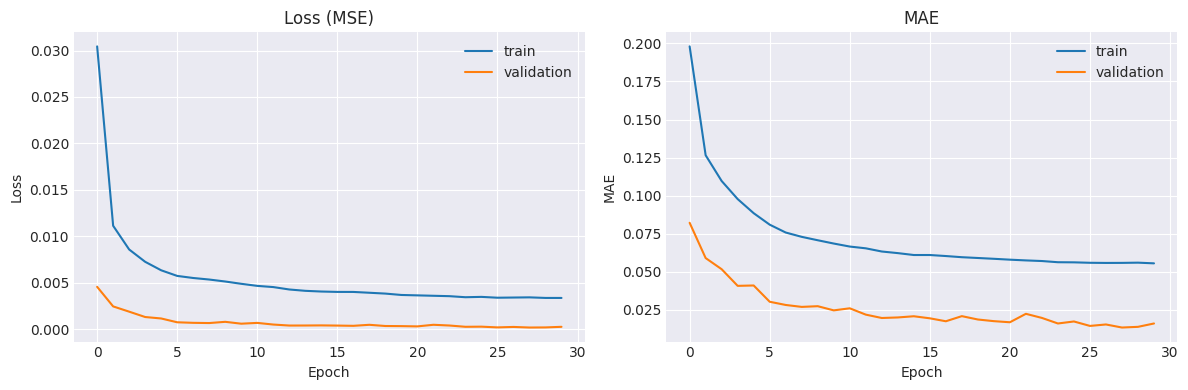

In [8]:
# ========================================
# CELLULE 8 - Entraînement (MODIFIÉE POUR 30 EPOCHS)
# ========================================

# configuration de l'entraînement
batch_size = 128
epochs = 30  # RÉDUIT DE 100 À 30 POUR GAGNER DU TEMPS

print(f"configuration de l'entraînement:")
print(f"- batch size: {batch_size}")
print(f"- epochs max: {epochs}")
print(f"- échantillons par epoch: {len(x_train)}")
print(f"- steps par epoch: {len(x_train) // batch_size}")

# entraînement avec poids d'échantillons
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val, w_val),
    sample_weight=w_train,
    callbacks=training_callbacks,
    verbose=1
)

# sauvegarde de l'historique
history_dict = history.history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

print("\n\nentraînement terminé.")
print(f"meilleur val_loss: {min(history_dict['val_loss']):.4f}")
print(f"epoch du meilleur modèle: {np.argmin(history_dict['val_loss']) + 1}")

# visualisation rapide
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# loss
axes[0].plot(history_dict['loss'], label='train')
axes[0].plot(history_dict['val_loss'], label='validation')
axes[0].set_title('Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# mae
axes[1].plot(history_dict['mae'], label='train')
axes[1].plot(history_dict['val_mae'], label='validation')
axes[1].set_title('MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

modèle chargé depuis best_model.keras

évaluation sur tous les ensembles...

dénormalisation des prédictions et targets...

RÉSULTATS FINAUX - Valeurs dénormalisées

Métriques globales:
       set   mae  rmse
     train 0.003 0.007
validation 0.003 0.007
      test 0.003 0.007


Métriques par target (MAE):

mortality_rate:
  train       : 0.0085
  validation  : 0.0085
  test        : 0.0085

transmission_rate:
  train       : 0.0004
  validation  : 0.0004
  test        : 0.0004

spatial_spread:
  train       : 0.0000
  validation  : 0.0000
  test        : 0.0000


Test de généralisation:
MAE validation: 0.0030
MAE test: 0.0030
Dégradation: +0.1%
✅ Généralisation acceptable


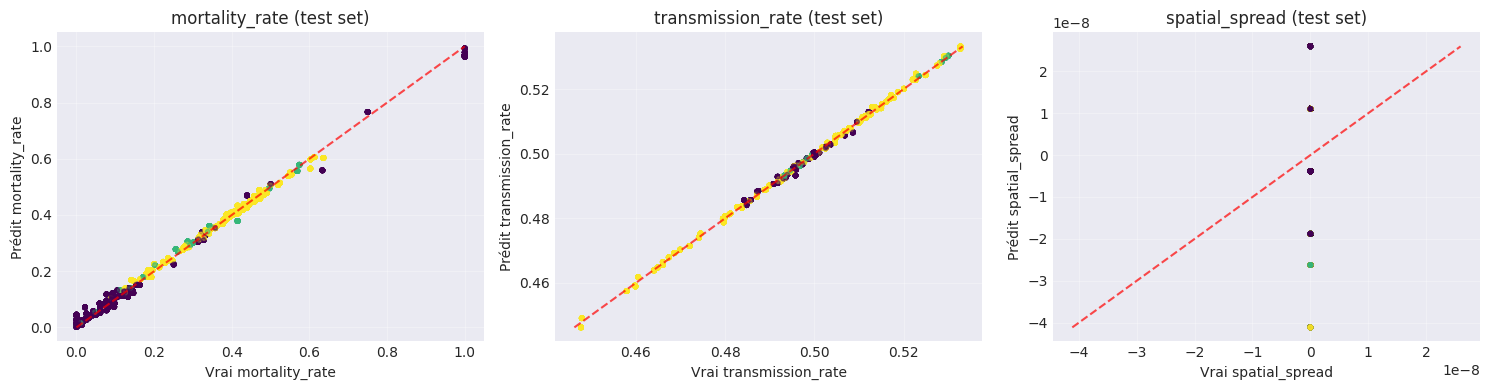


RAPPORT FINAL
Performance globale MAE test: 0.0030
Meilleure prédiction: 0.0000
Pire prédiction: 0.0085

Fichiers sauvegardés: test_evaluation_final.png, final_results.txt


In [9]:
# ========================================
# CELLULE 9 - Évaluation finale (VERSION CORRIGÉE)
# ========================================

# chargement du meilleur modèle
import tensorflow as tf
model = tf.keras.models.load_model('best_model.keras')
print("modèle chargé depuis best_model.keras")

# chargement des données de test
data = np.load('train_val_test_split.npz')
x_test, y_test, w_test = data['x_test'], data['y_test'], data['w_test']

# chargement des scalers pour dénormaliser
scaler_targets = joblib.load('scaler_targets.pkl')

# prédictions sur les 3 ensembles
print("\névaluation sur tous les ensembles...")
x_train, y_train, w_train = data['x_train'], data['y_train'], data['w_train']
x_val, y_val, w_val = data['x_val'], data['y_val'], data['w_val']

# prédictions (normalisées)
y_pred_train = model.predict(x_train, verbose=0)
y_pred_val = model.predict(x_val, verbose=0)
y_pred_test = model.predict(x_test, verbose=0)

# DÉNORMALISATION
print("\ndénormalisation des prédictions et targets...")
y_train_denorm = scaler_targets.inverse_transform(y_train)
y_val_denorm = scaler_targets.inverse_transform(y_val)
y_test_denorm = scaler_targets.inverse_transform(y_test)

y_pred_train_denorm = scaler_targets.inverse_transform(y_pred_train)
y_pred_val_denorm = scaler_targets.inverse_transform(y_pred_val)
y_pred_test_denorm = scaler_targets.inverse_transform(y_pred_test)

# calcul des métriques sur valeurs réelles
def calculate_metrics(y_true, y_pred, weights, set_name):
    """calcule les métriques pondérées pour un ensemble"""
    metrics = {'set': set_name}
    
    # métriques globales
    mse = np.average((y_true - y_pred)**2, weights=weights, axis=0).mean()
    mae = np.average(np.abs(y_true - y_pred), weights=weights, axis=0).mean()
    metrics['mse'] = mse
    metrics['mae'] = mae
    metrics['rmse'] = np.sqrt(mse)
    
    # métriques par target
    target_names = ['mortality_rate', 'transmission_rate', 'spatial_spread']
    for i, target in enumerate(target_names):
        target_mae = np.average(np.abs(y_true[:, i] - y_pred[:, i]), weights=weights)
        target_rmse = np.sqrt(np.average((y_true[:, i] - y_pred[:, i])**2, weights=weights))
        metrics[f'{target}_mae'] = target_mae
        metrics[f'{target}_rmse'] = target_rmse
    
    return metrics

# calcul pour chaque ensemble
train_metrics = calculate_metrics(y_train_denorm, y_pred_train_denorm, w_train, 'train')
val_metrics = calculate_metrics(y_val_denorm, y_pred_val_denorm, w_val, 'validation')
test_metrics = calculate_metrics(y_test_denorm, y_pred_test_denorm, w_test, 'test')

# affichage des résultats
print("\n" + "="*60)
print("RÉSULTATS FINAUX - Valeurs dénormalisées")
print("="*60)

metrics_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])
print("\nMétriques globales:")
print(metrics_df[['set', 'mae', 'rmse']].to_string(index=False))

print("\n\nMétriques par target (MAE):")
for target in ['mortality_rate', 'transmission_rate', 'spatial_spread']:
    print(f"\n{target}:")
    for metrics in [train_metrics, val_metrics, test_metrics]:
        print(f"  {metrics['set']:12s}: {metrics[f'{target}_mae']:.4f}")

# test de généralisation
val_mae = val_metrics['mae']
test_mae = test_metrics['mae']
degradation = (test_mae - val_mae) / val_mae * 100

print(f"\n\nTest de généralisation:")
print(f"MAE validation: {val_mae:.4f}")
print(f"MAE test: {test_mae:.4f}")
print(f"Dégradation: {degradation:+.1f}%")

if degradation < 20:
    print("✅ Généralisation acceptable")
else:
    print("⚠️ Dégradation importante")

# visualisation simple
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
target_names = ['mortality_rate', 'transmission_rate', 'spatial_spread']

for i, target in enumerate(target_names):
    ax = axes[i]
    ax.scatter(y_test_denorm[:, i], y_pred_test_denorm[:, i], 
              c=w_test, cmap='viridis', alpha=0.5, s=10)
    
    # ligne diagonale
    min_val = min(y_test_denorm[:, i].min(), y_pred_test_denorm[:, i].min())
    max_val = max(y_test_denorm[:, i].max(), y_pred_test_denorm[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    
    ax.set_xlabel(f'Vrai {target}')
    ax.set_ylabel(f'Prédit {target}')
    ax.set_title(f'{target} (test set)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_evaluation_final.png', dpi=150)
plt.show()

# rapport final
print("\n" + "="*60)
print("RAPPORT FINAL")
print("="*60)
print(f"Performance globale MAE test: {test_metrics['mae']:.4f}")
print(f"Meilleure prédiction: {min(test_metrics['mortality_rate_mae'], test_metrics['transmission_rate_mae'], test_metrics['spatial_spread_mae']):.4f}")
print(f"Pire prédiction: {max(test_metrics['mortality_rate_mae'], test_metrics['transmission_rate_mae'], test_metrics['spatial_spread_mae']):.4f}")

# sauvegarde des résultats
with open('final_results.txt', 'w') as f:
    f.write(f"MAE Test: {test_metrics['mae']:.4f}\n")
    f.write(f"Mortality Rate MAE: {test_metrics['mortality_rate_mae']:.4f}\n")
    f.write(f"Transmission Rate MAE: {test_metrics['transmission_rate_mae']:.4f}\n")
    f.write(f"Spatial Spread MAE: {test_metrics['spatial_spread_mae']:.4f}\n")

print("\nFichiers sauvegardés: test_evaluation_final.png, final_results.txt")